## Import

In [1]:
from pathlib import Path
import random
import glob

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_colwidth', None)

In [10]:
cd /home/sanjyot/latcom

/home/sanjyot/latcom


In [11]:
from preprocess import preprocess_labels, preprocess_image
from transform import construct_dataset
from models import load_nvidia

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
data_dir = Path('.').resolve() / 'dataset' / 'udacity_simulator' / 'tracks'
label_path = data_dir / 'driving_log.csv'

In [14]:
img_dir = data_dir / 'IMG'
img_count = len(list(img_dir.glob('*')))

lbl = pd.read_csv(
    label_path, 
    names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
)

print(f'Total images: {img_count}')
print(f'Total records: {len(lbl)}')

Total images: 97329
Total records: 32443


## Preprocess labels

In [92]:
downsample_ratio = 0.9  # Controls how much percentage of straight driving labels are discarded

lbl_fix = preprocess_labels(lbl, downsample_ratio)


Original size: 32443 | New size: 14245
Size reduced to 43.91%


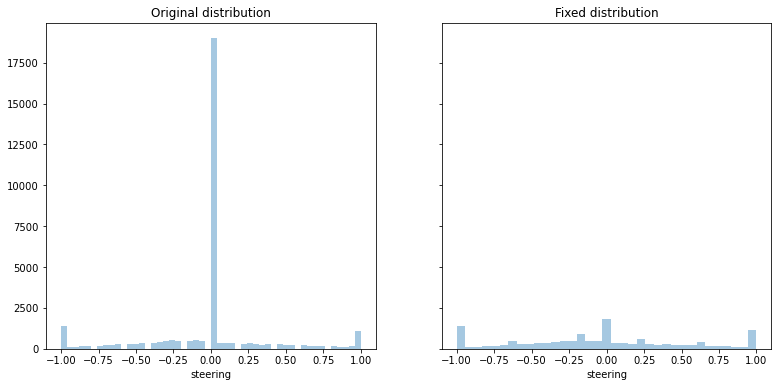

In [94]:
# Plot distribution change

fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
sns.distplot(lbl['steering'], ax=ax[0], kde=False)
sns.distplot(lbl_fix['steering'], ax=ax[1], kde=False)
ax[0].set_title('Original distribution')
ax[1].set_title('Fixed distribution')
_ = plt.plot()

## Preprocess images

(160, 320, 3)


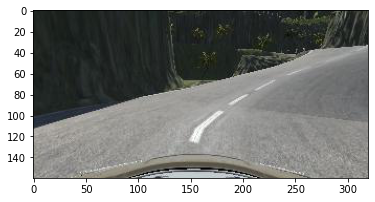

In [17]:
# Show sample image

index = 150
image_dir = data_dir / 'IMG'
sample_image_path = glob.glob(f'{str(image_dir)}/center*.jpg')[index]

img = cv.imread(sample_image_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print(img.shape)
_ = plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


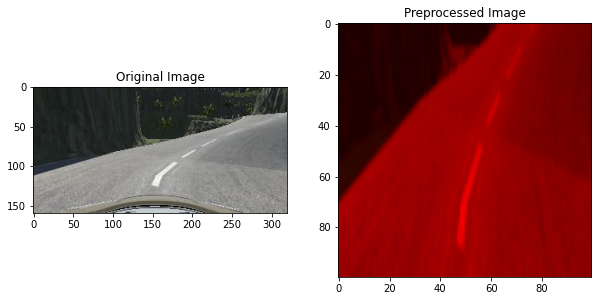

In [18]:
# Plot preprocessing result

original_image = cv.cvtColor(cv.imread(str(sample_image_path)), 
                             cv.COLOR_BGR2RGB)
preprocessed_image = preprocess_image(sample_image_path).numpy()

# noinspection PyRedeclaration
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
_ = plt.plot()

## Prepare training data

In [95]:
lbl_fix.head()

,center,left,right,steering,throttle,reverse,speed
12081,center_2019_04_02_18_07_20_284.jpg,left_2019_04_02_18_07_20_284.jpg,right_2019_04_02_18_07_20_284.jpg,0.30,0.000000,0.0,9.029948
24323,center_2019_04_02_18_21_36_250.jpg,left_2019_04_02_18_21_36_250.jpg,right_2019_04_02_18_21_36_250.jpg,0.45,0.000000,0.0,10.118900
1473,center_2019_04_02_19_27_19_179.jpg,left_2019_04_02_19_27_19_179.jpg,right_2019_04_02_19_27_19_179.jpg,-0.05,0.241263,0.0,14.156060
23704,center_2019_04_02_18_20_52_826.jpg,left_2019_04_02_18_20_52_826.jpg,right_2019_04_02_18_20_52_826.jpg,0.50,0.435241,0.0,9.546017
17525,center_2019_04_02_18_13_41_190.jpg,left_2019_04_02_18_13_41_190.jpg,right_2019_04_02_18_13_41_190.jpg,0.05,0.335320,0.0,1.649035


In [96]:
batch_size = 128

train, valid = construct_dataset(lbl_fix, data_dir, batch_size=batch_size, validation_split_ratio=0.2)
print(f'\nData tensor spec:\n{train.element_spec}')

Training samples: 11396
Validation samples: 2849

Data tensor spec:
(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))


## NVIDIA model

In [97]:
nvidia = load_nvidia()
nvidia.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 48)        43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

## Training

In [99]:
epochs = 10
model_name = f'nvidia_e{epochs}_bsize_{batch_size}'
model_path = Path('.') / 'models' / model_name

if list(model_path.parent.glob(f'{model_name}*')):
    print('Loading existing weights.')
    nvidia.load_weights(str(model_path))
else:
    print('No weights found. Training.')
    history = nvidia.fit(train, epochs=10, validation_data=valid)
    nvidia.save_weights(str(model_path))

Loading existing weights.


-----------

### MSE on models tried
ResNet + Dense model ~ 0.3

NVIDIA ~ 0.1

NVIDIA + tanh on last Dense ~ 0.1

------------

In [100]:
# Set baseline mse as the mse of a model whose prediction is the mean y value

sse = 0
count = 0
iteration = 0
y_valid = np.array([])

for valid_batch, train_batch in zip(valid.take(-1), train.take(-1)):
    y_valid_batch = valid_batch[-1].numpy()
    y_train_batch = train_batch[-1].numpy()
    
    iteration += 1
    y_valid = np.concatenate([y_valid, y_valid_batch])
    count += len(y_valid_batch)
    sse += np.sum((y_valid_batch - y_train_batch.mean())**2)

mean_steering = float(sse)/count
print(f'Mean predictor model MSE: {mean_steering}')

Mean predictor model MSE: 0.3074810677407616


Model validation MSE: 0.0948



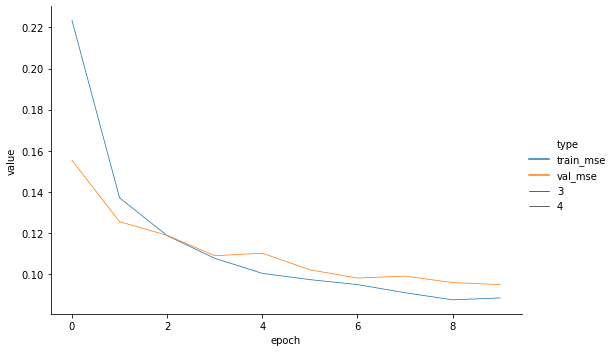

In [101]:
h = (
    pd.DataFrame(history.history)
    .reset_index()
    .rename(columns={'index': 'epoch', 'mse': 'train_mse'})
    .melt(
        id_vars='epoch',
        value_vars=['train_mse', 'val_mse'],
        var_name='type'   
    )
)

valid_mse = h[h['type'] == 'val_mse']['value'].iloc[-1]
print(f'Model validation MSE: {round(valid_mse, 4)}\n')

g = sns.relplot(x='epoch', y='value', hue='type', kind='line', data=h, aspect=1.5, size=4)

## Check predictions

In [102]:
y_pred = nvidia.predict(valid)

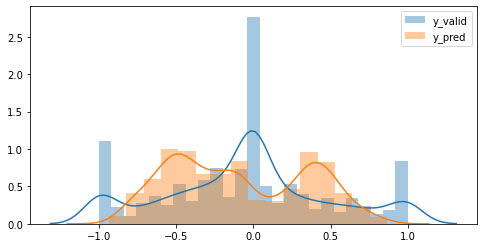

In [103]:
# Histogram of output distribution

fig, ax = plt.subplots(figsize=(8, 4))
g = sns.distplot(y_valid_all, label='y_valid', ax=ax)
sns.distplot(y_pred, label='y_pred', ax=ax)
plt.legend()
_ = plt.plot()

Better than the original ResNet + Dense model.

In [104]:
valid_batch = next(iter(valid))
pred_on_batch = nvidia.predict(valid_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean steering: 0.3074810677407616
Model steering: 0.39152392745018005
Original steering: 0.05


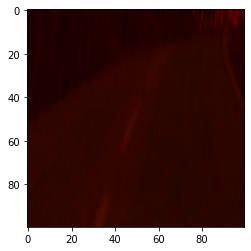

In [113]:
X_valid, y_valid = valid_batch[0].numpy(), valid_batch[1].numpy()

random_record = random.randint(0, batch_size - 1)
plt.imshow(X_valid[random_record])
print(f'Mean steering: {mean_steering}')
print(f'Model steering: {np.squeeze(pred_on_batch[random_record])}')
print(f'Original steering: {y_valid[random_record]}')

Much improvement from the ResNet model, can work with this for now.